#EECS 504 Final Project

### Bryan Edwards, Demba Komma, Leah Wu, Eric Shumaker
#### {bryaned, dbkomma, huiminwu, eshumake} @umich.edu


# Starting


In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torchsummary import summary
import cv2
import os

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")



PyTorch Version:  1.4.0
Torchvision Version:  0.5.0
Using the GPU!


## [1] Download Pascal VOC 2007 dataset.



In [0]:
!wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!tar -xf VOCtrainval_06-Nov-2007.tar

--2020-04-14 18:47:07--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

al_06-Nov-2007.tar   37%[======>             ] 162.90M   237KB/s    eta 17m 52s

KeyboardInterrupt: ignored

# [1.1] Process images by masking center region

In [0]:
# Create directory structure for dataloader 
if os.path.exists('./data'):
  ! rm -r ./data
os.mkdir('./data')
os.mkdir('./data/train')
os.mkdir('./data/train/sub')
os.mkdir('./data/test')
os.mkdir('./data/test/sub')
train_path = './data/train/sub'
test_path = './data/test/sub'

In [0]:
def process_image(img_path):
    """
    Resizes and masks image in specified path.

    Input:
    - img_path: path to image

    Output:
    - Image of size (454,227,3) containing resized original image in left half and
      resized, masked image in right half
    """
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256,256)) # Resize image to (227,227,3)

    # Create mask
    mask = 255 * np.ones_like(img)
    x,y,_ = mask.shape
    mask[int(x/3):int((2/3)*x), int(y/3):int((2/3)*y),:] = 0

    # Apply mask
    masked = cv2.bitwise_and(img,mask)

    # Concatenate original img with masked
    cat = np.hstack((img, masked))
    return cat
  

In [0]:
# # To clean folders
if len(os.listdir(train_path)) != 0:
  for root, dirs, files in os.walk(train_path):
      for img in files:
          os.remove(os.path.join(root, img))

  for root, dirs, files in os.walk(test_path):
      for img in files:
          os.remove(os.path.join(root, img))

In [0]:
path = './VOCdevkit/VOC2007/JPEGImages'
images = []

for filename in os.listdir(path):
    img = process_image(os.path.join(path, filename))
    if img is not None:
        images.append(img)

# Take last 500 images as test data
train = images[:-500]
test = images[-500:]

# Add training images to train directory
if len(os.listdir(train_path)) == 0:
    for i, img in enumerate(train):
        img_path = train_path + '/%d.jpg' % (i + 1)
        cv2.imwrite(img_path, img)
    print('Train images saved to train directory')
else:
    print('Please empty {} directory.'.format(train_path))

# Add test images to test directory
if len(os.listdir(test_path)) == 0:
    for i, img in enumerate(test):
        img_path = test_path + '/%d.jpg' % (i + 1)
        cv2.imwrite(img_path, img)
    print('Test images saved to test directory')
else:
    print('Please empty {} directory.'.format(test_path))

Train images saved to train directory
Test images saved to test directory


## [2] Build dataloaders for train and test

In [0]:
def load_data(path, subfolder, transform, batch_size, shuffle=True):
    """
    Data loader.

    Inputs:
    - path: path of the data.
    - subfolder: subfolder of the data.
    - transform: data transformation.
    - batch_size: the size of the batch
    - shuffle: if true, shuffle the data

    Outputs:
    - torch Dataloader
    """
    direc = path + '/' + subfolder
    dset = datasets.ImageFolder(direc, transform=transform)

    # For debugging faster, truncate data to 2500 images for training and 10 for validating
    if subfolder == 'train':
      dset_sub = Subset(dset, torch.arange(0, 2500))
    elif subfolder == 'test':
      dset_sub = Subset(dset, torch.arange(0, 10))

    dataloader = DataLoader(dset,batch_size=batch_size,shuffle=shuffle)
    return dataloader

In [0]:
# data_loader
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
train_loader = load_data('./data', 'train', transform, 1, shuffle=True)
test_loader = load_data('./data', 'test', transform, 10, shuffle=False)

#Sample Output used for visualization
test = test_loader.__iter__().__next__()[0]
img_size = test.size()[2]
fixed_y_ = test[:, :, :, 0:img_size]
fixed_x_ = test[:, :, :, img_size:]

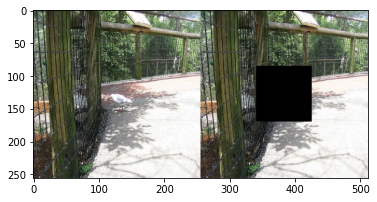

In [0]:
# plot sample image
example = train_loader.__iter__().__next__()[0][0].numpy().transpose((1, 2, 0))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
example = std * example + mean
plt.imshow(example)
plt.show()

## [3] Define Architecture

## RESNET

In [0]:
model = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.5.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.5.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.5.0', 'resnet152', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## [3] Define Architecture

3.1 Encoder

In [0]:
def get_res_block(dim=128, ksz=3, s=1):
  
  res = nn.Sequential(
                  nn.ReflectionPad2d(ksz//2),
                  nn.Conv2d(dim, dim, kernel_size=ksz, stride=s), 
                  nn.InstanceNorm2d(dim),
                  nn.ReLU(inplace = True),
                  nn.ReflectionPad2d(ksz//2),
                  nn.Conv2d(dim,dim,kernel_size=ksz, stride=s), 
                  nn.InstanceNorm2d(dim))
  return res





class Generator(nn.Module):
    def __init__(self, in_channels = 3):
        super(Generator, self).__init__()

        ##############################################################################
        # TODO: Build an encoder with the Resnet architecture.           #
        ##############################################################################
        #self.RP = nn.ReflectionPad2d(0)

        self.GC1 = nn.Sequential(
                                nn.ReflectionPad2d(4),
                                nn.Conv2d(3,32, kernel_size=9, stride=1),
                                nn.InstanceNorm2d(32),
                                nn.ReLU(inplace=True),
                                 
                                nn.Conv2d(32,64,kernel_size=3, stride=2, padding = 1),
                                nn.InstanceNorm2d(64),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(64,128, kernel_size=3, stride=2, padding = 1),
                                nn.InstanceNorm2d(128),
                                nn.ReLU(inplace=True))
        
        self.GR1 = get_res_block(dim=128)
        self.GR2 = get_res_block(dim=128)
        self.GR3 = get_res_block(dim=128)
        self.GR4 = get_res_block(dim=128)
        self.GR5 = get_res_block(dim=128)

        self.GC2 = nn.Sequential( 
                                nn.ConvTranspose2d(128,64,kernel_size=3, stride=2, padding = 1, output_padding=1),
                                nn.InstanceNorm2d(64),
                                nn.ReLU(inplace=True),

                                nn.ConvTranspose2d(64,32, kernel_size=3, stride=2, padding = 1, output_padding=1),
                                nn.InstanceNorm2d(32),
                                nn.ReLU(inplace=True),
                                 
                                nn.ReflectionPad2d(4),
                                nn.Conv2d(32,3, kernel_size=9, stride=1),
                                nn.InstanceNorm2d(3),
                                nn.ReLU(inplace=True))
        self._initialize_weights()
        

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.InstanceNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        '''
        Given an image x, return the encoded latent representation h.

        Args:
            x: torch.tensor

        Return: 
            out: torch.tensor
        '''
        #yrf  = self.RP(x)
        ygc0 = self.GC1(x)
        ygr1 = self.GR1(ygc1) + ygc0
        ygr2 = self.GR2(ygr1) + ygr1
        ygr3 = self.GR2(ygr2) + ygr2
        ygr4 = self.GR2(ygr3) + ygr3
        ygr5 = self.GR2(ygr4) + ygr4
        out  = self.GC2(ygr5)
        return out

In [0]:
# Print out the neural network architectures and activation dimensions.
# Verify that your network has the same architecture as the one we printed above.
generator = Generator().to(device)
summary(generator, [(3, 256, 256)])

NameError: ignored

3.2 Decoder

In [0]:
class Discriminator(nn.Module):
    def __init__(self, in_channels = 6, feat_dim=32):
        super(Discriminator, self).__init__()

        ##############################################################################
        # TODO: Build the decoder as specified above.                                #
        ##############################################################################  
        self.D_shared = nn.Sequential(
                        nn.Conv2d(in_channels, feat_dim, kernel_size=9, stride=1, padding=4),
                        nn.InstanceNorm2d(feat_dim), 
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),

                        nn.Conv2d(feat_dim, 64,kernel_size=3, stride=2, padding = 1),
                        nn.InstanceNorm2d(64),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),

                        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding = 1),
                        nn.InstanceNorm2d(128),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),

                        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding = 1),
                        nn.InstanceNorm2d(256),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True))
        
        self.D_pgan =  nn.Sequential(
                        nn.Conv2d(256, 512, kernel_size=3, stride=2, padding = 1),
                        nn.InstanceNorm2d(512),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),

                        nn.Conv2d(512, 512, kernel_size=3, stride=2, padding = 1),
                        nn.InstanceNorm2d(512),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),

                        nn.Conv2d(512, 1, kernel_size=3, stride=1, padding = 1))
        
        self.D_ggan =  nn.Sequential(
                        nn.Conv2d(256, 512, kernel_size=3, stride=2, padding = 1),
                        nn.InstanceNorm2d(512),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),

                        nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding = 1),
                        nn.InstanceNorm2d(1024),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),

                        nn.Conv2d(1024, 1, kernel_size=3, stride=1, padding = 1))
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.InstanceNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        
    def activate_gradients(self, net_gan=3, cond=False):
        """
        Enable or disable  gradients when computing losses
        net_gan = 0  gradients for shared weights
        net_gan = 1  gradients for shared patch gan weights
        net_gan = 2  gradients for shared global gan weights
        net_gan = 3  gradients for all weights
        """
        s_cond, pg_cond, g_cond = cond, cond, cond
        if(net_gan == 0):
            s_cond, pg_cond, g_cond = s_cond, !pg_cond, !g_cond
        elif(net_gan == 1):
            s_cond, pg_cond, g_cond = !s_cond, pg_cond, !g_cond
        elif(net_gan == 2):
            s_cond, pg_cond, g_cond = !s_cond, !pg_cond, g_cond
        elif(net_gan == 3):
            s_cond, pg_cond, g_cond = s_cond, pg_cond, g_cond
        else:
            return

        for param in self.D_shared.parameters():
            param.requires_grad = s_cond
        for param in self.D_pgan.parameters():
            param.requires_grad = pg_cond
        for param in self.D_ggan.parameters():
            param.requires_grad = g_cond
       
     


    def forward(self, x):
        '''
        Given latent representation h, reconstruct an image patch of size 64 x 64.

        Args:
            x: torch.tensor

        Return: 
            yp, yg
            yp: torch.tensor, patch gan output
            yg: torch.tensor, global gan output
        '''
        ys = self.D_shared(x)
        yp = self.D_pgan(ys)
        yg = self.D_ggan(ys)
        return yp, yg

In [0]:
# Print out the neural network architectures and activation dimensions.
# Verify that your network has the same architecture as the one we printed above.
discriminator = Discriminator().to(device)
summary(discriminator, [(6, 256, 256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]          15,584
    InstanceNorm2d-2         [-1, 32, 256, 256]               0
         LeakyReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
    InstanceNorm2d-5         [-1, 64, 128, 128]               0
         LeakyReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
    InstanceNorm2d-8          [-1, 128, 64, 64]               0
         LeakyReLU-9          [-1, 128, 64, 64]               0
           Conv2d-10          [-1, 256, 32, 32]         295,168
   InstanceNorm2d-11          [-1, 256, 32, 32]               0
        LeakyReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 512, 16, 16]       1,180,160
   InstanceNorm2d-14          [-1, 512,

3.3 U-Net Autoencoder

In [0]:
class InpaintModel(nn.Module)
    def __init__(self, lambda = [0.995, 0.0025, 0.0025]):
        self.D = Discriminator()
        self.G = Generator()
        self.G_L1_Loss = nn.L1Loss()
        self.D_PGAN_Loss = nn.BCEWithLogitsLoss()
        self.D_GGAN_Loss = nn.BCEWithLogitsLoss()
        self.G_Optim = optim.Adam(self.G.parameters(), lr=1e-3)
        self.D_PGAN_Optim = optim.Adam(self.D.D_pgan.parameters(), lr = 1e-3)
        self.D_GGAN_Optim = optim.Adam(self.D.D_ggan.parameters(), lr = 1e-3)
        self.D_SGAN_Optim = optim.Adam(self.D.D_shared.parameters(), lr = 1e-3)

    def set_inputs(self, x, y):
        self.x_input = x
        self.y_input = y
    
    def forward(self):
        self.y_fake = self.gnet(self.x_input)

    def train_networks(self):
        self.forward()
        #train discriminator network
        real_x_fake_y = torch.cat((self.x_input, self.y_fake), dim=1)
        real_x_real_y = torch.cat((self.x_input, self.y_input), dim=1)
        pred_fake_pgan, pred_fake_ggan = self.dnet(real_x_fake_y.detach())
        pred_real_pgan, pred_real_ggan = self.dnet(real_x_real_y.detach())
        
        # train pgan weights of discrimminator
        loss_d_pgan_fake = self.D_PGAN_Loss(pred_fake_pgan, False) 
        loss_d_pgan_real = self.D_PGAN_Loss(pred_real_pgan, True)
        loss_d_pgan = (loss_d_pgan_fake + loss_d_pgan_real)/2.0
        self.dnet.activate_gradients(net_gan=1, cond=True)
        self.D_PGAN_Optim.zero_grad();
        loss_d_pgan.backward()
        self.D_PGAN_Optim.step()

        # train ggan weights of discrimminator
        loss_d_ggan_fake = self.D_PGAN_Loss(pred_fake_ggan, False) 
        loss_d_ggan_real = self.D_PGAN_Loss(pred_real_ggan, True)
        loss_d_ggan = (loss_g_pgan_fake + loss_d_ggan_real)/2.0
        self.dnet.activate_gradients(net_gan=2, cond=True)
        self.D_GGAN_Optim.zero_grad();
        loss_d_ggan.backward()
        self.D_GGAN_Optim.step()

        #train shared weights of discrimminator
        loss_d_sgan = loss_d_ggan + loss_d_pgan
        self.dnet.activate_gradients(net_gan=0, cond=True)
        self.D_SGAN_Optim.zero_grad();
        loss_d_sgan.backward()
        self.D_SGAN_Optim.step()

        #train generator
        #first disable discriminator
        self.dnet.activate_gradients(net_gan=3, cond=False) 
        loss_g_rec = self.G_L1_Loss(self.y_fake, self.y_input)
        net_loss = lambda[0]*loss_g_rec + lambda[1]*loss_d_pgan + lambda[2]*loss_d_ggan
        self.G_Optim.zero_grad()
        net_loss.backward()
        self.G_Optim.step()

        return net_loss, loss_d_pgan, loss_d_ggan
        



class Autoencoder(nn.Module):
    def __init__(self, in_channels=3, feat_dim=64):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        '''
        Compress and reconstruct the input image with encoder and decoder.

        Args:
            x: torch.tensor

        Return: 
            x_: torch.tensor
        '''

        h = self.encoder(x)
        x_ = self.decoder(h)

        return x_

In [0]:
# verify that your autoconder's output
ae = Autoencoder().to(device)
summary(ae, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]          23,296
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 192, 7, 7]         307,392
              ReLU-5            [-1, 192, 7, 7]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              ReLU-8            [-1, 384, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         884,992
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

3.4 Train Autoencoder

## [4] Train



In [0]:
# Helper function for showing result.
def process_image(img):
    return (img.cpu().data.numpy().transpose(1, 2, 0) + 1) / 2

def show_result(G, x_, y_, num_epoch):
    predict_images = G(x_)

    fig, ax = plt.subplots(x_.size()[0], 3, figsize=(10,30))

    for i in range(x_.size()[0]):
        ax[i, 0].get_xaxis().set_visible(False)
        ax[i, 0].get_yaxis().set_visible(False)
        ax[i, 1].get_xaxis().set_visible(False)
        ax[i, 1].get_yaxis().set_visible(False)
        ax[i, 2].get_xaxis().set_visible(False)
        ax[i, 2].get_yaxis().set_visible(False)
        ax[i, 0].cla()
        ax[i, 0].imshow(process_image(x_[i]))
        ax[i, 1].cla()
        ax[i, 1].imshow(process_image(predict_images[i]))
        ax[i, 2].cla()
        ax[i, 2].imshow(process_image(y_[i]))
    
    plt.tight_layout()
    label_epoch = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0, label_epoch, ha='center')
    label_input = 'Input'
    fig.text(0.18, 1, label_input, ha='center')
    label_output = 'Output'
    fig.text(0.5, 1, label_output, ha='center')
    label_truth = 'Ground truth'
    fig.text(0.81, 1, label_truth, ha='center')

    plt.show()

# Helper function for counting number of trainable parameters.
def count_params(model):
    '''
    Counts the number of trainable parameters in PyTorch.
    Args:
        model: PyTorch model.
    Returns:
        num_params: int, number of trainable parameters.
    '''
    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])
    return num_params

In [0]:
# Hint: you could use following loss to complete following function
BCE_loss = nn.BCELoss().cuda()
L1_loss = nn.L1Loss().cuda()

def train(G, D, num_epochs = 20, only_L1 = False):
    hist_D_losses = []
    hist_G_losses = []
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
  
    # Adam optimizer
    G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,.999))
    D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,.999))

    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== END OF CODE ============== #

    print('training start!')
    start_time = time.time()
    for epoch in range(num_epochs):
        print('Start training epoch %d' % (epoch + 1))
        D_losses = []
        G_losses = []
        epoch_start_time = time.time()
        num_iter = 0

        for x_, _ in train_loader:
            
            y_ = x_[:, :, :, 0:img_size]
            x_ = x_[:, :, :, img_size:]
                
            x_, y_ = Variable(x_.cuda()), Variable(y_.cuda())

            # train discriminator D
            #++++++++++++++++++++++++++++++++++++++++++++++#
            #++++++++++++++++++++++++++++++++++++++++++++++#
            # ============== YOUR CODE HERE ============== # 
            D.zero_grad()
            gen = G(x_)

            D_real = D(x_, y_).squeeze()
            D_fake = D(x_, gen).squeeze()

            #Fill values initialized for real and fake
            fake = torch.zeros_like(D_fake)
            real = torch.ones_like(D_real)

            #Use loss function
            loss_D = (BCE_loss(D_real, real) + BCE_loss(D_fake, fake)) / 2
            
            loss_D.backward()
            D_optimizer.step()

            #++++++++++++++++++++++++++++++++++++++++++++++#
            #++++++++++++++++++++++++++++++++++++++++++++++#
             # ============== END OF CODE ============== #

            D_losses.append(loss_D)
            hist_D_losses.append(loss_D)

            # train generator G
            #++++++++++++++++++++++++++++++++++++++++++++++#
            #++++++++++++++++++++++++++++++++++++++++++++++#
            # ============== YOUR CODE HERE ============== # 
            G.zero_grad()
            gen = G(x_)

            D_res = D(x_, gen).squeeze()
            real = torch.ones_like(D_res)

            if(only_L1): #L1 loss only case
                loss_G = L1_loss(gen, y_)
            else:
                loss_G = BCE_loss(D_res, real) + (100 * L1_loss(gen, y_))
            
            loss_G.backward()
            G_optimizer.step()
      
            #++++++++++++++++++++++++++++++++++++++++++++++#
            #++++++++++++++++++++++++++++++++++++++++++++++#
            # ============== END OF CODE ================= #

            G_losses.append(loss_G)
            hist_G_losses.append(loss_G)
            num_iter += 1

        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print('[%d/%d] - using time: %.2f' % ((epoch + 1), num_epochs, per_epoch_ptime))
        print('loss of discriminator D: %.3f' % (torch.mean(torch.FloatTensor(D_losses))))
        print('loss of generator G: %.3f' % (torch.mean(torch.FloatTensor(G_losses))))
        print('Sample Image:')
        show_result(G, Variable(fixed_x_.cuda(), volatile=True), fixed_y_, (epoch+1))

    end_time = time.time()
    total_ptime = end_time - start_time

    return hist_D_losses, hist_G_losses



In [0]:
# Define network
G_100 = generator()
D_100 = discriminator()
G_100.weight_init(mean=0.0, std=0.02)
D_100.weight_init(mean=0.0, std=0.02)
G_100.cuda()
D_100.cuda()
G_100.train()
D_100.train()

#Report the architectures of your network
print(G_100)
print('Number of trainable parameters {}'.format(count_params(G_100)))

print(D_100)
print('Number of trainable parameters {}'.format(count_params(D_100)))

In [0]:
#training
# TODO: change_num_epochs if you want
hist_D_100_losses, hist_G_100_losses = train(G_100, D_100, num_epochs = 20, only_L1 = False)

In [0]:
# Define network
G_L1 = generator()
D_L1 = discriminator()
G_L1.weight_init(mean=0.0, std=0.02)
D_L1.weight_init(mean=0.0, std=0.02)
G_L1.cuda()
D_L1.cuda()
G_L1.train()
D_L1.train()

#training
# TODO: change_num_epochs if you want
hist_D_L1_losses, hist_G_L1_losses = train(G_L1, D_L1, num_epochs = 10, only_L1 = True)

Visualize Losses

In [0]:
# plot the G/D loss history v.s. Iteration in one plot
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== # 
num_iter = []
for i in  range(8000):
  num_iter.append(i)

plt.figure()
plt.plot(num_iter, hist_D_100_losses)
plt.plot(num_iter, hist_G_100_losses)
plt.legend(['D Loss', 'G Loss'])
plt.xticks(num_iter)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss History for G and D vs. Iteration')
plt.show()

#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# =============== END OF CODE ================ #



In [0]:
# plot the G/D loss history v.s. Iteration in one plot
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== # 

# num_iter = hist_D_L1_losses.size[0]

num_iter = []
for i in  range(4000):
  num_iter.append(i)

plt.figure()
plt.plot(num_iter, hist_D_L1_losses)
plt.plot(num_iter, hist_G_L1_losses)
plt.legend(['D Loss', 'G Loss'])
plt.xticks(num_iter)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss History for G and D vs. Iteration')
plt.show()

#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# =============== END OF CODE ================ #

## [5] Visualization



In [0]:
# TODO